In [ ]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Leveraging sequences in deep learning

In [ ]:
''' What is a sequence?

* Sequence: a data stream that is meaningfully ordered in time.
  e.g., sentence, the order matters, music, medical time series data.
  - You can leverage the temporal sequence to make a prediction about the next word.
  - Measurements of the electrical activity produced by the heart.
    And different characteristics of these kinds of time series signals will indicate some problems with the heart.

* Why do we care about sequences in DL?
- Sequence data contain structured information over time that we can use to help us understand the signal.
- Sequences contain sequential information (temporal autocorrelation structure) that can be leveraged to predict the future or
  categorize the past.
- With CNNs, we took advantage of the fact that neighboring pixels in an image were correlated with each other.
- Here with sequences, we want deep learning model to learn that neighboring elements in the sequence are correlated.
- Main goals: (1) Predict the future or (2) assign a category (classification).
- One of the main goals of RNNs, to use information from the past that you already have available to make prediction
  about the possibility, the probability of certain values happening in the future.
- We also use RNNs to classify or categorize time series data.

* Representing time series data in numbers
- Time series data like data that were measured from, a temperature sensor or an electrode or political polling data or so on.
  These data correspond to the average daily sunlight hours in different months of the year.
  These kinds of data are easy to represent bacause they are already represented numerically.
  We just need to organize these data in a data matrix or a table. Actually we will need to convert these into PyTorch tensors.
  Then the goal of the model is going to be to predict the daylight hours based on the numerical value of the month.
  But these numbers here, the data and the numerical values representing those data can be arbitrary.
  That means that you have the flexibility to choose a mapping that makes most sense given the problem and given how
  you want to interpret the data.

* Rrepresenting letters and words
1) Entire words can be represented as numbers.
2) Bag of words: to have a list (python dictionary) and keep track of the word and the number of occurrences or the frequency of that word.
    - representation that the temporal sequence is completely lost.
3) One-hot encoding.
    - Not a great way to represent language bacause it fails to incorporate or it fails to leverage the natural correlation between letters.
4) Embedding matrix.

* Issues with non-RNN architectures
1) Limitations of FFN architectures for sequences:
  - Ignores sequence information.
  - Requres fixed sequence (input) length.
  - Learned parameters not shared across the sequence.

2) Limitation of CNN architectures for sequences:
  - Can leverage sequence information in some cases
    (e.g., converting a time series into an image).
  - Requires fixed sequence length (image size).
  - Works in some cases, but usually suboptimal.

=> So the idea of RNNs (recurrent neural networks) is that they are specially designed, custom tailored
  for learning patterns in temporally sequenced data.

  '''

# How RNNs work

In [ ]:
'''
* Basic RNN architecture
- We have the inputs. Those get passed through a hidden layer (or maybe multiple hidden layers)
  and those feed into some output layer where a prediction or a categorization is made.
- One difference is "recurrence", the hidden layer activation is feeding back into itself.
  Transformation which mathematically is represented as a weights matrix.

- Wih is the weights matrix that transforms the input into the hidden layer.
- Who is the weights matrix that transfroms the hidden layer activation into the outputs.
- What's new about RNNs, we have Whh, transformation that takes the hidden layer activation and transfroms it back into itself.
  So it feeds information back into itself.

- This recurrence happens over time or over different elements of a sequence.

- Inputs are changing at each step and so are the hidden layer activations and the predicted outputs.
  But what is constant over these different elements of the sequence are the weights matrices.
- So the same transformation is being applied at each step of this sequence.

- Hidden layer activation is the weighted combination of the inputs
  plus the weighted combination of the hidden layer from the previous time step.

- Number of inputs and outputs is a design choice that you can make, which depends on the exact type of problem that
  you're trying to solve.

* Backprop "through time"
- The goal of training a deep learning network is to adjust the numerical values inside these weight matrices to maximize
  its performance, which generally we take to mean minimizing a loss function.
- The exact type of loss function that you use depends on the kind of problem.
- Now all the backprop prodecures are exactly the same as for other deep learning architectures.
- The loss function propagates backwards through the network.
- The partial derivatives are computed with respect to the weights,
  and the weights are then adjusted according to the learning rate times that derivative.

* Problems with backprop in RNN
- The main problem with backpropagation in RNN is, the gradient gets pushed through so many layers
  that you run the risk of vanishing or exploding gradients.
- We had this kind of problem with CNNs, and there it was relatively easy to solve, for example, through regularization.
- But these kinds of tricks don't really work with RNNs.
- That's because these are all same weights, matrices being applied over and over again.
- So you can't just renormalize each time you pass the gradient along.

- Overly sensitive to recent inputs, low sensitivity to distant inputs.
- Risk of vanishing and exploding gradients.
- RNNs are great when important characteristics are a few time-steps back (like an AR model in signal processing).
- RNN-extensions give better performance: LSTM and GRU.

'''

# The RNN classes in PyTorch

In [ ]:
'''
* Organizing inputs into RNNs
- Input size: Number of feature dimensions (e.g., number of data channels.) Often set to 1.
- Sequence length: Length of data snippet used for learning.
- Batch size: Number of sequences to input per epoch.
- Hidden size: Number of units in the hidden layer.
- Number of layers: Number of hidden layers stacked on each other.
'''

## Explore the RNN type

In [ ]:
# set layer parameters
input_size = 9                  # number of features to extract (e.g., number of data channels)
hidden_size = 16             # number o units in the hidden state
num_layers = 1               # number of vertical stacks of hidden layers (note: only the final leyer gives an output)
actfunc = 'tanh'
bias = True

# create an RNN instance
rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity=actfunc, bias=bias)
rnn

RNN(9, 16)

In [ ]:
# check out the source code for more detailed info about this class
??nn.RNN

In [ ]:
# set data parameters
seq_length = 5
batch_size = 2

# create some data
X = torch.rand(seq_length, batch_size, input_size)

# create a hidden layer (typically initialized as zeros)
hidden = torch.zeros(num_layers, batch_size, hidden_size)

# run some data through the model and show the output sizes
y, h = rnn(X, hidden)
print(f'   Input shape: {list(X.shape)}')
print(f'Hidden shape: {list(h.shape)}')
print(f'Output shape: {list(y.shape)}')

   Input shape: [5, 2, 9]
Hidden shape: [1, 2, 16]
Output shape: [5, 2, 16]


In [ ]:
# Default hidden state is all zeros if nothing specified:
y, h1 = rnn(X, hidden)
print(h1), print('\n\n')

y, h2 = rnn(X)
print(h2), print('\n\n')

# they're the same! (meaning default=zeros)
print(h1-h2)

tensor([[[ 0.4287,  0.6106, -0.4256,  0.1973,  0.2277, -0.0638,  0.0531,
           0.2246,  0.0205, -0.0050,  0.2040,  0.2790, -0.4921,  0.1120,
           0.0155,  0.3436],
         [ 0.4031,  0.5549, -0.6221,  0.0044, -0.0401,  0.0194, -0.1399,
          -0.0409,  0.2821, -0.2300,  0.4712,  0.4843, -0.5366,  0.2119,
           0.1433,  0.5593]]], grad_fn=<StackBackward0>)



tensor([[[ 0.4287,  0.6106, -0.4256,  0.1973,  0.2277, -0.0638,  0.0531,
           0.2246,  0.0205, -0.0050,  0.2040,  0.2790, -0.4921,  0.1120,
           0.0155,  0.3436],
         [ 0.4031,  0.5549, -0.6221,  0.0044, -0.0401,  0.0194, -0.1399,
          -0.0409,  0.2821, -0.2300,  0.4712,  0.4843, -0.5366,  0.2119,
           0.1433,  0.5593]]], grad_fn=<StackBackward0>)



tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<SubBackward0>)


In [ ]:
# Check out the learned parameters and their sizes
for p in rnn.named_parameters():
    if 'weight' in p[0]:
        print(f'{p[0]} has size {list(p[1].shape)}')

weight_ih_l0 has size [16, 9]
weight_hh_l0 has size [16, 16]


## Create a DL model class

In [ ]:
class RNNnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # store parameters
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):

        print(f'Input: {list(x.shape)}')

        # initialize hidden state for first input
        hidden = torch.zeros(self.num_layers, batch_size, self.num_hidden)
        print(f'Hidden: {list(hidden.shape)}')

        # run through the RNN layer
        y, hidden = self.rnn(x, hidden)
        print(f'RNN-out: {list(y.shape)}')
        print(f'RNN-hidden: {list(hidden.shape)}')

        # pass the RNN output through the linear output layer
        o = self.out(y)
        print(f'Output: {list(o.shape)}')

        return o, hidden

In [ ]:
# create an instance of the model and inspect
net = RNNnet(input_size, hidden_size, num_layers)
print(net), print()

# and check out all learnable parameters
for p in net.named_parameters():
    print(f'{p[0]} has size {list(p[1].shape)}')

RNNnet(
  (rnn): RNN(9, 16)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

rnn.weight_ih_l0 has size [16, 9]
rnn.weight_hh_l0 has size [16, 16]
rnn.bias_ih_l0 has size [16]
rnn.bias_hh_l0 has size [16]
out.weight has size [1, 16]
out.bias has size [1]


In [ ]:
# test the model with some data
# create some data
X = torch.rand(seq_length, batch_size, input_size)
y = torch.rand(seq_length, batch_size, 1)
yHat, h = net(X)

# try a loss function
lossfunc = nn.MSELoss()
loss = lossfunc(yHat, y)
print()
print(loss)

Input: [5, 2, 9]
Hidden: [1, 2, 16]
RNN-out: [5, 2, 16]
RNN-hidden: [1, 2, 16]
Output: [5, 2, 1]

tensor(0.0958, grad_fn=<MseLossBackward0>)


# Predicting alternating sequences

## Create temporal sequence data

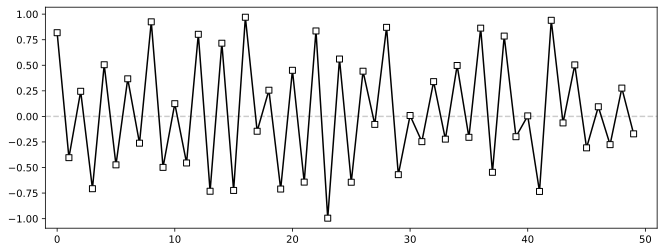

In [ ]:
# import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1)**i

plt.figure(figsize=(11,4))
plt.plot([-1, N+1], [0,0], '--', color=[.8,.8,.8])
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-1, N+1])
plt.show()

## Create a class for the DL model

In [ ]:
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # RNN layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):

        # run through the RNN layer
        y, hidden = self.rnn(x) # no explicit hidden state initialization

        # and the output (linear) layer
        y = self.out(y)

        return y, hidden

In [ ]:
# network parameters
input_size = 1                  # "channels" of data
num_hidden = 5              # breadth of model (number of units in hidden layers)
num_layers = 1               # depth of model (number of "stacks" of hidden layers)
seq_length = 9                # number of datapoints used for learning in each segment
batch_size = 1                # Note: the training code is actually hard-coded to orgganize data into batchsize=1

# create an instance of the model and ispect
net = rnnnet(input_size, num_hidden, num_layers)

X = torch.rand(seq_length, batch_size, input_size)
y, h = net(X)
print(X.shape)
print(y.shape)  # note: one output per sequence element, generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [ ]:
# test the model with some data
somedata = data[:seq_length].view(seq_length, 1, 1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfunc = nn.MSELoss()
lossfunc(finalValue, data[seq_length].view(1,1))

tensor(0.4517, grad_fn=<MseLossBackward0>)

## Train the model and show performance

In [ ]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=.001)

# initialize losses
losses = np.zeros(numepochs)
sign_accuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seg_losses = []
    seg_acc = []
    hidden_state = torch.zeros(num_layers, batch_size, num_hidden) # reset the hidden state on each epoch

    for timei in range(N-seq_length):

        # grab a snippet of data
        X = data[timei:timei+seq_length].view(seq_length, 1, 1)
        y = data[timei+seq_length].view(1,1)

        # forward pass and loss
        yHat, hidden_state = net(X)
        finalValue = yHat[-1]
        loss = lossfunc(finalValue, y) # compare final value of output

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seg_losses.append(loss.item())

        # also get sign accuracy
        truesign = np.sign(torch.squeeze(y).numpy())
        predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
        accuracy = 100 * (truesign==predsign)
        seg_acc.append(accuracy)

    # average losses from this epoch
    losses[epochi] = np.mean(seg_losses)
    sign_accuracy[epochi] = np.mean(seg_acc)

    msg = f'Finished epoch {epochi+1} / {numepochs}'
    sys.stdout.write('\r' + msg)

Finished epoch 30 / 30

In [ ]:
truesign

-1.0

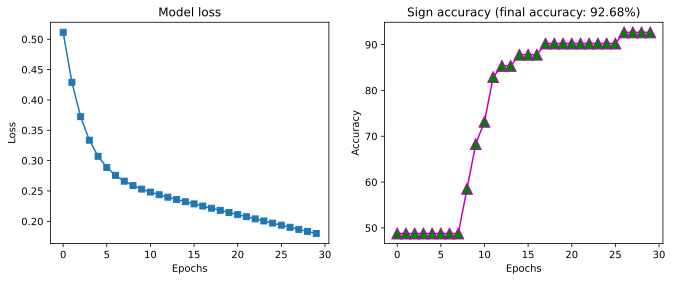

In [ ]:
# let's see how the model did!

fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(sign_accuracy, 'm^-', markerfacecolor='g', markersize=11)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)' % sign_accuracy[-1])

plt.show()

## Now test the network!

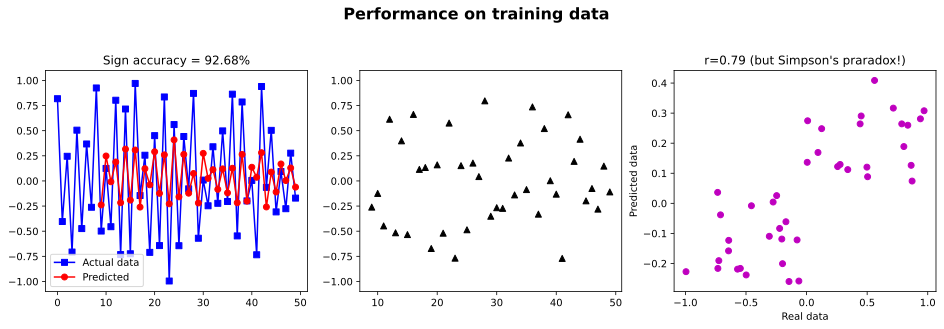

In [ ]:
# initialize hidden state
h = np.zeros((N, num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan

# loop over time segments
for timei in range(N-seq_length):

    # grab a snippet of data
    X = data[timei:timei+seq_length].view(seq_length, 1, 1)

    # forward pass and loss
    yy, hh = net(X)
    yHat[timei+seq_length] = yy[-1]
    h[timei+seq_length, :] = hh.detach()

# compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
sign_accuracy = 100 * np.mean(truesign[seq_length:] == predsign[seq_length:])

# plot!
fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(data, 'bs-', label='Actual data')
ax[0].plot(yHat, 'ro-', label='Predicted')
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title('Sign accuracy = %.2f%%' % sign_accuracy)
ax[0].legend()

ax[1].plot(data-yHat, 'k^')
ax[1].set_ylim([-1.1, 1.1])

ax[2].plot(data[seq_length:], yHat[seq_length:], 'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seq_length:], yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's praradox!)")

plt.suptitle('Performance on training data', fontweight='bold', fontsize=16, y=1.1)
# plt.tight_layout()
plt.show()

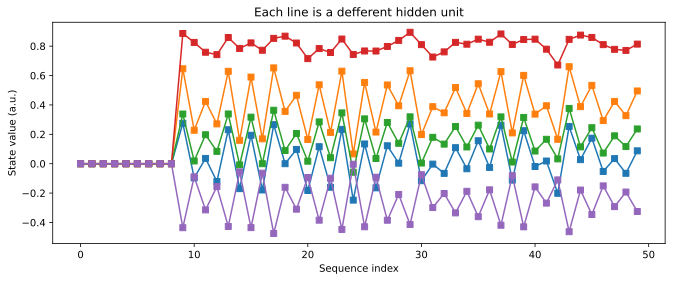

In [ ]:
# show the hidden "states" (units activations)
plt.figure(figsize=(11,4))

plt.plot(h, 's-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a defferent hidden unit')
plt.show()

## Test with new data

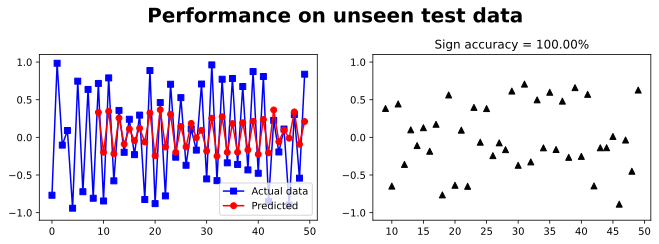

In [ ]:
# Create a new data WITH FLIPPED SIGNS!
newdata = torch.zeros(N)
for i in range(N):
    newdata[i] = torch.rand(1) * (-1)**(i+1)

# now test the network!
# note: no learning here!

h = np.zeros((N, num_hidden))

yHat = np.zeros(N)
yHat[:] = np.nan

for timei in range(N-seq_length):

    # grab a snippet of data
    X = newdata[timei:timei+seq_length].view(seq_length,1,1)

    # foward pass and loss
    yy, hh = net(X)
    yHat[timei+seq_length] = yy[-1]
    h[timei+seq_length,:] = hh.detach()

# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
sign_accuracy = 100 * np.mean(truesign[seq_length:] == predsign[seq_length:])

fig, ax = plt.subplots(1,2,figsize=(11,3))
ax[0].plot(newdata, 'bs-', label='Actual data')
ax[0].plot(yHat, 'ro-', label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %sign_accuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.10/dist-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/loc

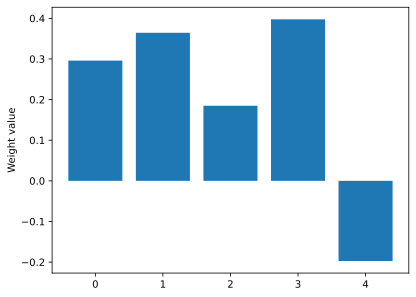

In [ ]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()

# Sine wave extrapolation

## Create temporal sequence data

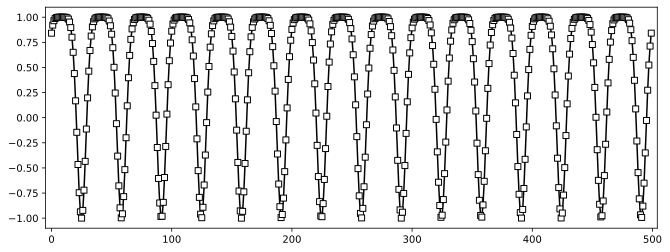

In [ ]:
N = 500

time = torch.linspace(0, 30*np.pi, N)
data = torch.sin(time + torch.cos(time))

plt.figure(figsize=(11,4))
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-5,N+4])
plt.show()

## Create a class for the DL model

In [ ]:
class rnnnet(nn.Module):
    def __init__(self):
        super().__init__()

        # RNN layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x, h):

        # run through the RNN layer
        y, hidden = self.rnn(x, h)

        # and the output (linear) layer
        y = self.out(y)

        return y, hidden.detach()

In [ ]:
# network parameters
input_size = 1
num_hidden = 9
num_layers = 1
seq_length = 30
batch_size = 1

# create an instance of the model and inspect
net = rnnnet()

X = torch.rand(seq_length, batch_size, input_size)
y, h = net(X, None) # none is for empty hidden state input
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force an "many-to-one" design.
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


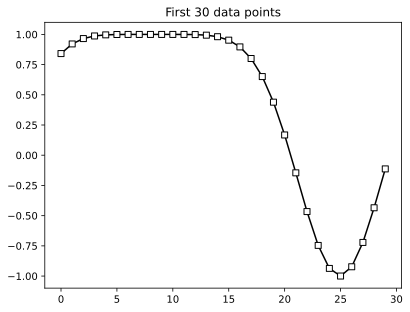

In [ ]:
# is it enough data?
plt.plot(data[:seq_length], 'ks-', markerfacecolor='w')
plt.title(f'First {seq_length} data points')
plt.show()

In [ ]:
''' Is this amount of data sufficient for you to really understand what's going on with this time series signal?
=> It's difficult to know a priori how to set these parameters.
Yout have to look at your data, you have to think carefully about these parameters.
Definitely feel free to visualize things like this as much as possible.
And, ultimately you just have to have a little bit of intuition, a little bit of trial and error experimentation.

'''

In [ ]:
# test the model with some data
somedata = data[:seq_length].view(seq_length, 1, 1)
y = net(somedata, None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfunc = nn.MSELoss()
lossfunc(finalValue, data[seq_length].view(1,1))

tensor(0.0007, grad_fn=<MseLossBackward0>)

## Train the model and show performance

In [ ]:
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet()
optimizer = torch.optim.SGD(net.parameters(), lr=.001)

# initialize losses
losses = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seg_losses = []
    hidden_state = None

    for timei in range(N-seq_length):

        # grab a snippet of data
        X = data[timei:timei+seq_length].view(seq_length, 1, 1)
        y = data[timei+seq_length].view(1,1)

        # forward pass and loss
        yHat, hidden_state = net(X, hidden_state)
        finalValue = yHat[-1]
        loss = lossfunc(finalValue, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seg_losses.append(loss.item())

    # average losses from this epoch
    losses[epochi] = np.mean(seg_losses)

    msg = f'Finished epoch {epochi + 1} / {numepochs}'
    sys.stdout.write('\r' + msg)

Finished epoch 30 / 30

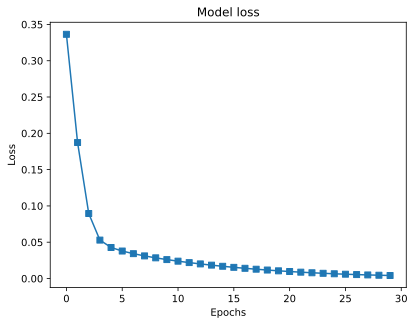

In [ ]:
# let's see how the model did!
plt.plot(losses, 's-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

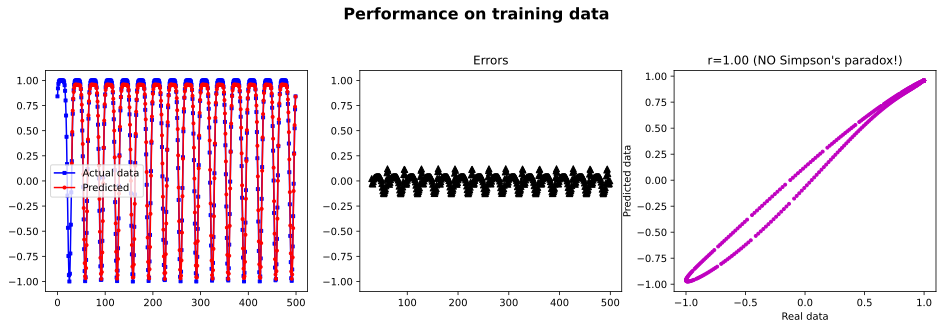

In [ ]:
# now test the network!

h = np.zeros((N, num_hidden))

yHat = np.zeros(N)
yHat[:] = np.nan

hh = None
for timei in range(N-seq_length):

    # grab a snippet of data
    X = data[timei:timei+seq_length].view(seq_length, 1, 1)

    # forward pass
    yy, hh = net(X, hh)
    yHat[timei+seq_length] = yy[-1]
    h[timei+seq_length, :] = hh.detach()

# plot!
fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data, 'bs-', label='Actual data', markersize=3)
ax[0].plot(yHat, 'ro-', label='Predicted', markersize=3)
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(data-yHat, 'k^')
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seq_length:], yHat[seq_length:], 'mo', markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seq_length:], yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data', fontweight='bold', fontsize=16, y=1.1)
plt.show()

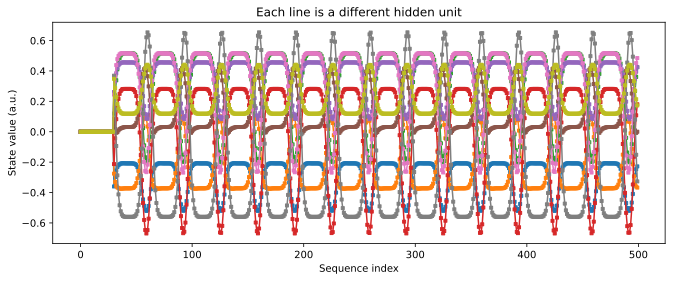

In [ ]:
# show the hidden "state" (units activations)
plt.figure(figsize=(11,4))

plt.plot(h,'s-', markersize=3)
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.10/dist-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/loc

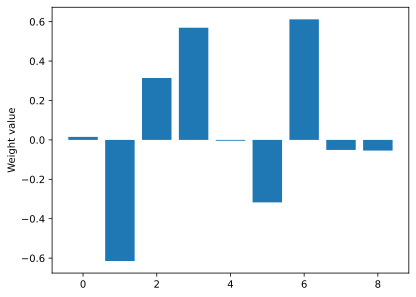

In [ ]:
# plot the weights for the input -> hidden layers
plt.bar(range(num_hidden), net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()

## Test with new data

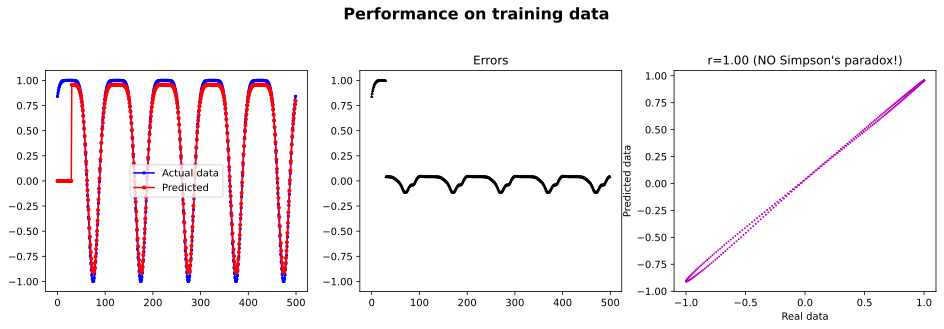

In [ ]:
# Create new data (different frequency)
time = torch.linspace(0, 10*np.pi, N)
newdata1 = torch.sin(time + torch.cos(time))

# Create new data (different function)
time = torch.linspace(0, 30*np.pi, N)
newdata2 = torch.sin(time+torch.sin(time))

# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None
for timei in range(N-seq_length):

    X = newdata1[timei:timei+seq_length].view(seq_length, 1, 1)

    yy, h = net(X, h)
    yHat[timei+seq_length] = yy[-1]

# plotting
fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata1, 'bs-', label='Actual data', markersize=2)
ax[0].plot(yHat, 'ro-', label='Predicted', markersize=3)
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(newdata1-yHat, 'k^', markersize=2)
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata1[seq_length:], yHat[seq_length:], 'mo', markersize=1)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata1[seq_length:], yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data', fontweight='bold', fontsize=16, y=1.1)
plt.show()

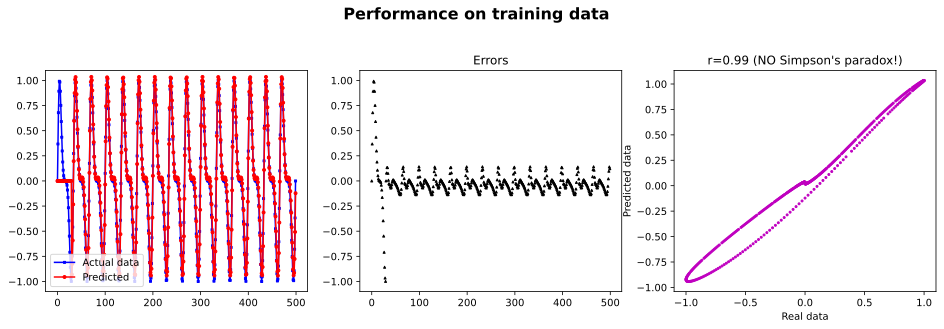

In [ ]:
# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None
for timei in range(N-seq_length):

    X = newdata2[timei:timei+seq_length].view(seq_length, 1, 1)

    yy, h = net(X, h)
    yHat[timei+seq_length] = yy[-1]

# plotting
fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata2, 'bs-', label='Actual data', markersize=2)
ax[0].plot(yHat, 'ro-', label='Predicted', markersize=3)
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(newdata2-yHat, 'k^', markersize=2)
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata2[seq_length:], yHat[seq_length:], 'mo', markersize=2)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata2[seq_length:], yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data', fontweight='bold', fontsize=16, y=1.1)
plt.show()

## Longer-term extrapolation

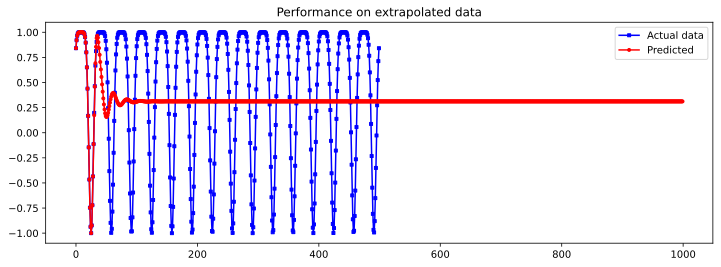

In [ ]:
# using original data

# create a signal 2x as long
yHat = torch.zeros(2*N) # torch, not np!
yHat[:N] = data
h = None

for timei in range(2*N-seq_length):

  # grab a snippet of data
  X = yHat[timei:timei+seq_length].view(seq_length,1,1)

  # forward pass and loss
  yy,h = net(X,h)
  yHat[timei+seq_length] = yy[-1]

# convert back to np for plotting
yHat = yHat.detach()

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(data,'bs-',label='Actual data',markersize=3)
plt.plot(yHat,'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()

In [ ]:
# 1) Extrapolation was awful! Maybe the model is too simple? Try increasing the sequence length and the number
#    of hidden units. Does that help the extrapolation?

# More on RNNs: Hidden states, embeddings

In [ ]:
'''
* hidden state at each point t: the non-linear transformation, typically tanh, of the weighted combination of the input plus
  weighted combination of the previous hidden states.

- The hidden state should be initialized to zeros at the start of each sequence.
- Otherwise the model starts learning the sequence biased by the hidden states from the previous sequence
  (which could be totally different!).

* Embeddings
- One-hot encoding: means that each letter is represented by a sparse vector that is all zeros
  and one one for the index corresponding to that letter catogory.
- One-hot encoding is simple, easy to implement, requires no parameters, and has nice mathematical properties (pairwise orthogonal).
- But it fails to capture the correlation pattern in real data (language).

=> A learned embeddings matrix addresses this limitation.

- An embeddings matrix is a different way of representing letters or words or any other category
  using a set of learned weights that reflects the intrinsic relationships between the different letters.

- Each letter (or word or atom) is represented as an N-dimensional vector.
- Letters with similar vectors (quantified as correlation or cosine similarity) are semantically related.
- Sequences can be generated by probabilistically picking subsequent letters that are more semantically related
  (e.g., "th" is more likely than "tq").
- Embeddings matrices are simply weights; they are initialized as random and learned through G.D.
- The embeddings matrix can be analyzed to find structure in the data (e.g., PCA or MDS).
- Learned embedding matrices contain empirical and learned relationships between the different classes in your dataset.
  You can do a lot of interesting, insightful, and detailed analyses with them like principle components analysis or multidimensional scaling.
  You can try to cluster different items in your dataset according to their correlations of embedding vectors and so on.

'''

# GRU and LSTM

In [ ]:
'''
* Limitations of RNNs
- Highly sensitive to recent inputs.
- Low sensitivity to distant inputs.
- Risk of vanishing and exploding gradients.
- RNNs are great when important characteristics are a few time-steps back (like an AR model in signal processing).
- RNN-extensions give better performance: LSTM and GRU.

* What is a "gate"?
- the sigmoid activation function.
- the key point about a sigmoid function is that most of the values are very close to zero or very close to one.
- So when the input is relatively far away from zero, then the output quickly gets pushed to zero or to one.
- When multiplying other variables, the sigmoid can switch off (0) or on (1) the variable, thus gating information routing.

- So if we have the output of this sigmoid multiplying some other set of data, some other representations, numerical representations,
  this can act as a gate to switch off those representations by setting them to be zero or something pretty small and close to zero.
- Or we can preserve those activations by setting them to be close to one.
=> That's the idea what people mean when they use this term "gate: in the context of LSTMs and GRUs.

'''

In [ ]:
'''
* Gated recurrent unit (GRU)
- Preserve representations of information over time,
  and that is done by figuring out which sequence elements, so which parts of the hidden state to preserve and which to update.

1) Reset gate: Combines current input and previous hidden states to decide how much of the past to update.
                        Variable r is ~0 or ~1.
                        This r variable acts as a gate that will dampen or preserve information.
                        The model will learn how much of the past to reset versus how much of the past to allow to go through learning.

2) Update gate: Combines current input and previous hidden states to decide what information to update (the hidden state items).
                          Variable z is ~0 or ~1.


3) New information: Combines current input and previous hidden states to create a new candidate hidden state.
                                Variable n is [-1, +1].
                                There's a tanh, instead of a sigmoid.
                                This is not functionally acting as a gate. It is representing information.
                                And not simply use the previous hidden state.
                                Instead, use the hidden state that is multiplied or scaled by, it's element-wise scaled by the reset gate.
                                Variable r is going to knock out some of these hidden state elements or allow them to be preserved.
                                So model is going to learn that some information in the hidden state should be knocked out,
                                and that's because the model learned that it's unimportant information.
                                It does not need to be remembered over time.
                                That would be for elements where r is zero.
                                Where r is one or close to one then it means that that piece of information is important.
                                It should persist over time, it should continue to be rememberd over time.
                                This variable n is, like a suggestion for new hidden state.
                                The actual new hidden state at time step i is more involved.

4) Output: Weighted combination of to-remember new state(n) and to-forget old state(h t-1).
                 Scaled by z. We don't want to change the entire hidden state too quickly. That could be unstable and volatile.
                 So instead of replacing the hidden state, modify it by adding on n.
                 How much of n do we add? That's what variable z encodes.
                 So the update gate (z) determines the balance between preserving old imformation in h of t-1, and a little bit in n of t,
                 versus updating with new information, which is in n.

- GRU has many more learned parameters than the standard RNN.
  And that means it can learn more abstract and complex relationships, but also means that it requires more computation time and more data to train.
'''

In [ ]:
'''
* Long short-term memory (LSTM)

- LSTMs have three inputs. 1) the input x, 2) h of t-1, hidden state from the previous time point,
  3) c of t-1, cell state (how the LSTM preserves a long-term memory trace).

- C is a different input representation from the hidden states.

1) Forget gate: Combines current input and previous hidden states
                         to decide which previous samples to forget and which to remember.
                         Variable f is ~0 or ~1.

2) Input gate: Combines current input and previous hidden states
                      to decide which current samples to forget and which to remember.
                      Variable i in ~0 or ~1.
                      Functionally kind of the opposite of the forget gate,
                      so the input gate determines the current data and the hidden state values
                      and how much those should be remembered.
                      So that variable i is going to multiply other variable, g.

3) Cell gate: Combines current input and previous hidden states to compute the actual representations
                     (like "activations" in FFNs).
                     Variable g ranges between -1 and +1.
                     These are the actual learned numerical representations of the data that are updated into the cell state.

- We have the f gate and that can knock items out of the cell state. So it's gonna knock out items in c that are learned to be unimportant.
  And then we have the i gate, and that determines how much to add or replace to the cell state.
  And the g variable is what actually goes into the new state.

4) Output gate: Combines current input and previous hidden states, and current cell states,
                         to compute the output of the LSTM cell (hidden state).
                         Variable o ranges between 0 and +1.
                         These weights are learned to modify the output of the LSTM unit.
                         So, variable o is not the output itself,
                         this is a variable learned that decides how much to combine or weights the information from previous values of c in the new output h.

5) Hidden state: Combination of previous hidden state and current input, and newly computed cell state.

6) Cell state: To-remember previous cell state plus to-remember current cell state.

'''

In [ ]:
''' When to use which?

* Standard RNN: Simple, fewext parameters. Good for sequences with short patterns.

* GRU: More complex than standard RNNs, but simpler than LSTMs.
            Trains fast and highly scalable, but needs more data than RNNs.

* LSTM: Most complex, requires more training data and computation time.
              Explicitly includes a memory trace. Good for longer sequences or complex patterns.
'''

In [ ]:
''' Recent exciting trends in RNNS

* Encoder-decoder: Like autoencoders for sequences.

* Transformer: Uses "attention" (weighting by significance) and context-relevance.

* Hierarchical models: Different layers see different lengths (allows for global/local interactions).

* Many others: Search for NLP - natural language processing.
'''

# The LSTM and GRU classes

## Explore the LSTM type

In [ ]:
# set layer parameters
input_size = 9                  # number of features to extract (e.g., number of data channels)
hidden_size = 16             # number of units in the hidden state
num_layers = 2               # number of vertical stacks of hidden layers (note: only the fifnal layer gives an output)

In [ ]:
# create an LSTM instance
lstm = nn.LSTM(input_size, hidden_size, num_layers)
lstm

LSTM(9, 16, num_layers=2)

In [ ]:
# check out the source for more detailed info about this class
??nn.LSTM

In [ ]:
# set data parameters
seq_length = 5
batch_size = 2

# create some data
X = torch.rand(seq_length, batch_size, input_size)

# create initial hidden states (typically initialized as zeros)
H = torch.zeros(num_layers, batch_size, hidden_size)
C = torch.zeros(num_layers, batch_size, hidden_size)

# the input is actually a tuple of (hidden, cell)
hiddeninputs = (H,C)

# run some data through the model and show the output sizes
y, h = lstm(X, hiddeninputs)

print(f'   Input shape: {list(X.shape)}')
print(f'Hidden shape: {list(h[0].shape)}')
print(f'     Cell shape: {list(h[1].shape)}')
print(f'Output shape: {list(y.shape)}')

   Input shape: [5, 2, 9]
Hidden shape: [2, 2, 16]
     Cell shape: [2, 2, 16]
Output shape: [5, 2, 16]


In [ ]:
# Check out the learned parameters and their sizes
for p in lstm.named_parameters():
    if 'weight' in p[0]:
        print(f'{p[0]} has size {list(p[1].shape)}')

# 64 = 4 * 16 (16: number of units in hidden layer, 4: all four of these weights matrices are concatenated together)

weight_ih_l0 has size [64, 9]
weight_hh_l0 has size [64, 16]
weight_ih_l1 has size [64, 16]
weight_hh_l1 has size [64, 16]


## Create a DL model class

In [ ]:
class LSTMnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # store parameters
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, num_hidden, num_layers)

        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):

        print(f'Input: {list(x.shape)}')

        # run through the LSTM layer
        y, hidden = self.lstm(x)
        print(f'LSTM-out: {list(y.shape)}')
        print(f'LSTM-hidden: {list(hidden[0].shape)}')
        print(f'LSTM-cell: {list(hidden[1].shape)}')

        # pass the LSTM output through the linear output layer
        o = self.out(y)
        print(f'Output: {list(o.shape)}')

        return o, hidden

In [ ]:
# create an instance of the model and inspect
net = LSTMnet(input_size, hidden_size, num_layers)
print(net)
print()

# and check out all learnable parameters
for p in net.named_parameters():
    print(f'{p[0]:>20} has size {list(p[1].shape)}')

LSTMnet(
  (lstm): LSTM(9, 16, num_layers=2)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

   lstm.weight_ih_l0 has size [64, 9]
   lstm.weight_hh_l0 has size [64, 16]
     lstm.bias_ih_l0 has size [64]
     lstm.bias_hh_l0 has size [64]
   lstm.weight_ih_l1 has size [64, 16]
   lstm.weight_hh_l1 has size [64, 16]
     lstm.bias_ih_l1 has size [64]
     lstm.bias_hh_l1 has size [64]
          out.weight has size [1, 16]
            out.bias has size [1]


In [ ]:
# test the model with some data
# create some data
X = torch.rand(seq_length, batch_size, input_size)
y = torch.rand(seq_length, batch_size, 1)

yHat, h = net(X)

lossfunc = nn.MSELoss()
lossfunc(yHat, y)

Input: [5, 2, 9]
LSTM-out: [5, 2, 16]
LSTM-hidden: [2, 2, 16]
LSTM-cell: [2, 2, 16]
Output: [5, 2, 1]


tensor(0.7434, grad_fn=<MseLossBackward0>)

## GRU

In [ ]:
# create a GRU instance
gru = nn.GRU(input_size, hidden_size, num_layers)
gru

GRU(9, 16, num_layers=2)

In [ ]:
??nn.GRU

In [ ]:
# create some data and a hidden state
X = torch.rand(seq_length, batch_size, input_size)
H = torch.zeros(num_layers, batch_size, hidden_size)

# run some data through the model and show the output sizes
y, h = gru(X, H) # No cell states in GRU!

print(f'   Input shape: {list(X.shape)}')
print(f'Hidden shape: {list(h.shape)}')
print(f'Output shape: {list(y.shape)}')

   Input shape: [5, 2, 9]
Hidden shape: [2, 2, 16]
Output shape: [5, 2, 16]


In [ ]:
# Check out the learned parameters and their sizes
for p in gru.named_parameters():
    print(f'{p[0]:<15} has size {list(p[1].shape)}')

# 48 = 3 * 16 (16: number of units in hidden layer, 3: all four of these weights matrices are concatenated together)

weight_ih_l0    has size [48, 9]
weight_hh_l0    has size [48, 16]
bias_ih_l0      has size [48]
bias_hh_l0      has size [48]
weight_ih_l1    has size [48, 16]
weight_hh_l1    has size [48, 16]
bias_ih_l1      has size [48]
bias_hh_l1      has size [48]


# Lorem ipsum

## Paste and process text data

In [ ]:
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent molestie sapien auctor eleifend egestas. Fusce at purus sodales, viverra nunc quis, consequat augue. Vestibulum eget tempus lorem, et blandit dui. Suspendisse ac gravida odio. Maecenas consequat tristique mi, vitae rutrum lacus pulvinar vitae. Nunc ullamcorper nulla eu velit vehicula, vitae facilisis erat dignissim. Proin consectetur nec lacus ac pellentesque. Nulla purus ligula, commodo id tellus id, efficitur varius massa. Phasellus et volutpat felis, gravida imperdiet justo. Cras metus velit, aliquet et tristique sit amet, elementum ultrices dui. Nullam condimentum quis orci quis pretium. Mauris tincidunt ante nec ex tristique, a commodo quam eleifend. Nam convallis ultrices magna fringilla porta. Phasellus non lobortis nisi. Donec nec lectus ligula. Maecenas id purus at lectus auctor finibus sit amet et enim. Vivamus nibh urna, dapibus sed porta in, sodales vitae elit. Fusce sed facilisis elit, ut porta massa. Vivamus blandit congue erat eget rutrum. Nullam mollis, eros et laoreet euismod, nunc mi condimentum eros, mollis pretium mi orci in nibh. Pellentesque rhoncus justo et pretium tempor. Ut gravida egestas quam, sit amet sagittis tortor scelerisque in. Vestibulum sed odio urna. Donec semper quis erat quis laoreet. Ut malesuada volutpat sem ac luctus. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Praesent sed bibendum sapien, id imperdiet elit. Vestibulum erat lorem, finibus eu enim non, posuere tempus velit. Vestibulum a massa id orci interdum malesuada eu vel tellus. Proin tempus viverra scelerisque. Nullam suscipit laoreet nisl, id consequat sem porttitor et. Integer congue urna lacus, ac feugiat arcu tincidunt eget. Aliquam erat volutpat. Vivamus accumsan semper gravida. Mauris porta magna vitae semper hendrerit. Vestibulum urna nunc, faucibus sit amet auctor sed, scelerisque nec est. Nulla ut sagittis urna. Proin fermentum turpis non iaculis tincidunt. Maecenas scelerisque rutrum hendrerit. Sed fermentum vehicula molestie. Sed nec rutrum nisi. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Cras malesuada, magna in ornare pretium, leo tellus sodales tortor, sit amet fermentum nunc odio eu enim. Quisque placerat eros ornare nulla vulputate, at efficitur sem convallis. Sed libero risus, viverra a turpis a, sollicitudin feugiat neque. Fusce vitae erat commodo, consectetur lacus vel, sollicitudin lorem. Nunc sed risus arcu. Pellentesque nec eleifend risus, a fringilla odio. Sed auctor augue a rutrum maximus. Maecenas suscipit tellus sem, vitae suscipit nisl euismod a. Phasellus elementum sodales urna, ac fringilla mi malesuada id. Suspendisse sollicitudin rhoncus dolor ut consequat. Duis tincidunt quis neque nec tincidunt. Fusce vitae sagittis nulla. Suspendisse ac varius mauris. Maecenas dapibus posuere velit, nec pellentesque quam sagittis a. Nunc aliquet justo vitae justo pharetra consectetur. Nam porttitor at nisl sit amet ullamcorper. Sed rutrum, nulla ac porttitor pulvinar, nisi leo hendrerit magna, non luctus nibh risus eget est. Quisque pulvinar rutrum vehicula. Ut tempor placerat sollicitudin. Etiam pharetra sit amet nulla at fringilla. Pellentesque feugiat odio ligula, ac ullamcorper leo vulputate a. Vestibulum placerat interdum arcu, sit amet ullamcorper ipsum finibus sed. Aliquam erat volutpat. Nam tincidunt, augue eu eleifend dictum, tellus sem blandit sem, et pulvinar ex purus sed leo. Nullam ultricies tincidunt sem, imperdiet condimentum ex porttitor at. Nunc id lacus sit amet nibh elementum dignissim. Nam facilisis tincidunt tincidunt. Suspendisse in mauris vel dui imperdiet facilisis. Aenean eu neque tortor. Cras sit amet mi nibh. Mauris sit amet feugiat nulla. Nam ac leo ipsum. Vestibulum id enim sit amet est pharetra consectetur. Vestibulum et lacus sed ipsum placerat blandit vitae quis nisl. Curabitur lacus est, euismod non accumsan sed, accumsan nec lectus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Maecenas ultrices eros in erat molestie interdum. Nunc et tellus orci. Maecenas et magna ornare mauris sodales malesuada. Duis iaculis ipsum non laoreet porta. Aenean vitae purus tempor, porttitor arcu id, bibendum enim. Aliquam faucibus congue eros, eget feugiat risus venenatis a. Duis malesuada, sem eu mattis placerat, velit lectus varius tellus, eget placerat nibh quam non turpis. Donec auctor pellentesque odio, nec pulvinar nisi fermentum eget. Mauris eget eleifend metus. Mauris venenatis arcu semper erat facilisis, malesuada viverra tortor imperdiet. Nunc ut quam sit amet ex varius euismod. Mauris eleifend lectus venenatis risus mattis consequat. Nulla a eros non erat egestas consequat nec volutpat neque. In diam nulla, mollis ut semper nec, vulputate luctus odio. Morbi ac elementum quam, ut vestibulum sem. Ut tincidunt sapien ac fermentum ullamcorper. Cras convallis tortor quis malesuada dignissim. Suspendisse rutrum cursus diam, in consequat nisi vulputate sit amet. Nunc euismod consectetur libero eu pulvinar. Ut finibus scelerisque lectus vel auctor. Vivamus congue non sem et tincidunt. Vestibulum vehicula erat sed nisi mattis aliquet. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Etiam pulvinar tortor enim, vel blandit mauris sodales quis. Ut bibendum dui non posuere pellentesque. Phasellus metus diam, blandit accumsan porta a, pharetra nec nulla. Nam pulvinar, lacus et ornare luctus, magna orci tincidunt lorem, porttitor tincidunt enim mi a ligula. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Etiam quis mi porta, mattis velit vel, rhoncus nisi. Etiam lobortis placerat lacus.'.lower()
# generated at https://www.lipsum.com/

print(text)

lorem ipsum dolor sit amet, consectetur adipiscing elit. praesent molestie sapien auctor eleifend egestas. fusce at purus sodales, viverra nunc quis, consequat augue. vestibulum eget tempus lorem, et blandit dui. suspendisse ac gravida odio. maecenas consequat tristique mi, vitae rutrum lacus pulvinar vitae. nunc ullamcorper nulla eu velit vehicula, vitae facilisis erat dignissim. proin consectetur nec lacus ac pellentesque. nulla purus ligula, commodo id tellus id, efficitur varius massa. phasellus et volutpat felis, gravida imperdiet justo. cras metus velit, aliquet et tristique sit amet, elementum ultrices dui. nullam condimentum quis orci quis pretium. mauris tincidunt ante nec ex tristique, a commodo quam eleifend. nam convallis ultrices magna fringilla porta. phasellus non lobortis nisi. donec nec lectus ligula. maecenas id purus at lectus auctor finibus sit amet et enim. vivamus nibh urna, dapibus sed porta in, sodales vitae elit. fusce sed facilisis elit, ut porta massa. vivamu

In [ ]:
# get all the unique characters
unique_characters = set(text)
print(unique_characters)

{'q', ' ', 'l', 'g', 'j', 'f', 'd', 'a', 'e', 'm', 'v', 'p', ';', 'n', 'o', 'x', 'b', 'i', 'r', 's', 'c', 't', 'u', 'h', ',', '.'}


In [ ]:
# look-up tables to convert characters to indices and vice-versa
number2letter = dict(enumerate(unique_characters))
letter2number = { l : i for i, l in number2letter.items() }

print(letter2number)
print()
print(number2letter)

{'q': 0, ' ': 1, 'l': 2, 'g': 3, 'j': 4, 'f': 5, 'd': 6, 'a': 7, 'e': 8, 'm': 9, 'v': 10, 'p': 11, ';': 12, 'n': 13, 'o': 14, 'x': 15, 'b': 16, 'i': 17, 'r': 18, 's': 19, 'c': 20, 't': 21, 'u': 22, 'h': 23, ',': 24, '.': 25}

{0: 'q', 1: ' ', 2: 'l', 3: 'g', 4: 'j', 5: 'f', 6: 'd', 7: 'a', 8: 'e', 9: 'm', 10: 'v', 11: 'p', 12: ';', 13: 'n', 14: 'o', 15: 'x', 16: 'b', 17: 'i', 18: 'r', 19: 's', 20: 'c', 21: 't', 22: 'u', 23: 'h', 24: ',', 25: '.'}


In [ ]:
# convert the text from characters into numbers

# note the inputs to zeros()
data = torch.zeros((len(text), 1), dtype=torch.int64, device=device)
for i, ch in enumerate(text):
    data[i] = letter2number[ch]

tensor([[ 2],
        [14],
        [18],
        ...,
        [22],
        [19],
        [25]], device='cuda:0')


Text(0, 0.5, 'Character label')

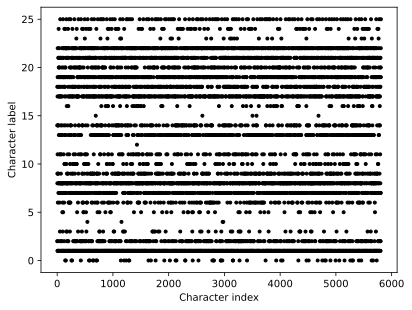

In [ ]:
# let's see the data!
print(data)
plt.plot(data.cpu().numpy(), 'k.')
plt.xlabel('Character index')
plt.ylabel('Character label')

## Create an LSTM model class

In [ ]:
class lstmnet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(input_size, input_size)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

        # linear output layer
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):

        # embedding layer
        embedding = self.embedding(x)

        # run through the LSTM layer
        y, h = self.lstm(embedding, h)

        # and the output (linear) layer
        y = self.out(y)

        return y, (h[0].detach(), h[1].detach()) # just the numerical values for h

In [ ]:
# meta-parameters
hidden_size = 512               # size of hidden state
seq_length = 80                  # length of squence
num_layers = 3                   # number of stacked hidden layers
epochs = 10                        # training epochs

In [ ]:
# model instance
lstm = lstmnet(len(unique_characters), len(unique_characters), hidden_size, num_layers).to(device)

# loss function and optimizer
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=.001)

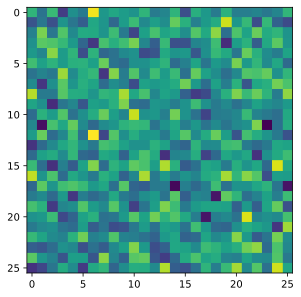

In [ ]:
# visualize the randomly initialized embedding matrix
I = next(lstm.embedding.named_parameters())
plt.imshow(I[1].cpu().detach());

## Train the model

In [ ]:
losses = np.zeros(epochs)

# loop over epochs
for epochi in range(epochs):

    # initialize loss for this epoch, and hidden state
    txtloss = 0
    hidden_state=None

    # loop through the entire text character-wise
    for txtloc in range(0, len(text)-seq_length):

        # get input and target(shifted version of input)
        x = data[txtloc : txtloc+seq_length]
        y = data[txtloc+1 : txtloc+seq_length+1]

        # forward pass
        output, hidden_state = lstm(x, None)

        # compute loss
        loss = lossfunc(torch.squeeze(output), torch.squeeze(y))
        txtloss += loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average losses for this epoch (run through the entire text)
    losses[epochi] = txtloss / txtloc

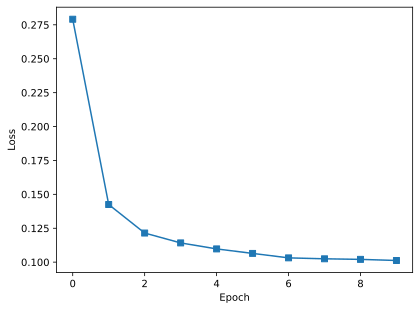

In [ ]:
# check out the losses
plt.plot(losses, 's-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# reconstructing a character sequence from number sequence
t = ''
for l in x:
    t += number2letter[l.item()]

t

'iam quis mi porta, mattis velit vel, rhoncus nisi. etiam lobortis placerat lacus'

## Generate new lorem ipsum text

In [ ]:
# how many chracters to generate?
lorem_length = 200

# random character from data to begin
x = torch.tensor(letter2number['x']).view(1,1).to(device)
lorem = number2letter[x.item()]

# initialize the hidden state
hidden_state = None

# generate the text!
for i in range(lorem_length):

    # push a letter through the LSTM
    output, hidden_state = lstm(x, hidden_state)

    # get the maximum output and replace input data
    index = torch.argmax(output).item()
    x[0][0] = index

    # append that output to the text
    lorem += number2letter[index]

# what's it say?!??!?
lorem

'x porta, mattis velit vel, rhoncus nisi. etiam lobortis placerat lacus et malesuada fames ac turpis egestas. etiam quis mi porta, mattis velit vel, rhoncus nisi. etiam lobortis placerat lacus et malesu'

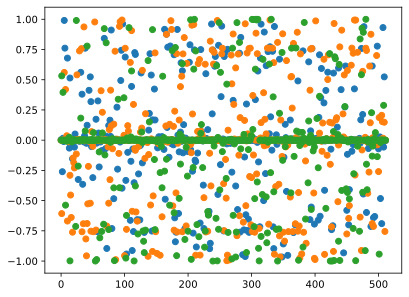

In [ ]:
# plot hidden states
for i in range(num_layers):
  plt.plot(hidden_state[0][i,0,:].cpu().numpy(),'o');

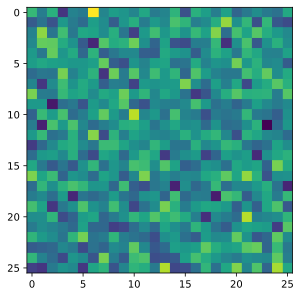

In [ ]:
# visualize the learned embeddings matrix
I = next(lstm.embedding.named_parameters())
I = I[1].cpu().detach().numpy()
plt.imshow(I);

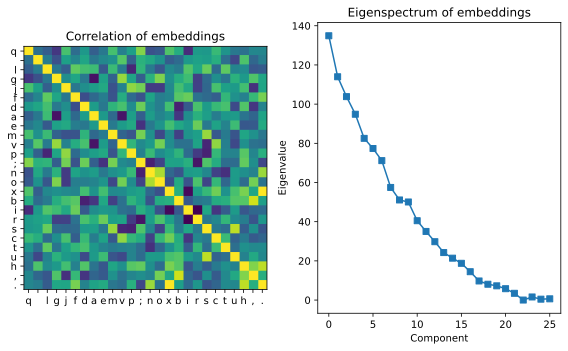

In [ ]:
# FYI, lots can be done with this matrix, e.g., PCA...
d,V = np.linalg.eig(I@I.T)

fig,axs = plt.subplots(1,2,figsize=(8,5))
axs[0].imshow(np.corrcoef(I),vmin=-.5,vmax=.5)
axs[0].set_title('Correlation of embeddings')
axs[0].set_xticks(range(len(letter2number.keys())))
axs[0].set_xticklabels(letter2number.keys())
axs[0].set_yticks(range(len(letter2number.keys())))
axs[0].set_yticklabels(letter2number.keys())

axs[1].plot(d,'s-')
axs[1].set_xlabel('Component')
axs[1].set_ylabel('Eigenvalue')
axs[1].set_title('Eigenspectrum of embeddings')

plt.tight_layout()
plt.show()

In [ ]:
# 1) The model seems to work well with the current parameters. But does it need so many hidden units and layers?
#    Try it again using one layer and 50 hidden units. Compare the loss function (quantitative) and the generated
#    text (qualitative) with the current instantiation.
#
# 2) In the video, I discussed that the embeddings matrix does not need to be square. Make it 2x as wide (thus, it
#    will be a 26x52 matrix). What needs to be changed in the code?
#
# 2) Lorem ipsum is already gibberish text (though each word is a plausible word). Replace the text with real text,
#    e.g., something you wrote, or perhaps copy text from a wiki page or a short story. Is the generated text still
#    nonsense words or real words? (Note that training could take a really long time if you use a really long text.)
#